**Author: Indonesia Sovereign Insurance Team**

# Health Insurance Cross Selling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score,roc_curve

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from imblearn import over_sampling,under_sampling
from sklearn.ensemble import RandomForestClassifier

# Background

Indonesia Sovereign Insurance (ISI) was originally an insurance company that only focused on **health insurance services**. Seeing the potential that exists in India, ISI plans to provide **vehicle insurance services** as well with the objective to**increase the company's profits**. To make this new service successful, ISI plans to use a **cross-selling strategy**.

Basically, cross-selling is a strategy to approach consumers who have **previously used the company's products**. In ISI case, the approach was made to consumers who had **previously used health insurance services**. The **Sales Agent Team** was asked to succeed this strategy by taking a personal approach to each customer. However, the sales agent team **encountered problems** when approaching the customer.

Based on the report from the Sales Agent team, the cross-selling strategy was **considered ineffective**. From all consumers who have been contacted by the sales agent, **only 12% are interested** in using vehicle insurance. Apart from these problems, contacting all consumers who use health services is also considered inefficient due to **limited time and human resources** in the Sales Agent team itself and the operation cost are too big. To solve this problem, sales agent team ask data science team to give the solution.

We offer 2 solutions, business insights and a machine learning model. With demographic data, vehicle profiles, and policy types from health insurance service customers, first the data science team will create business insights that can help the sales agent team to understand health medical customers better. Furthermore, the data science team will provide strategic recommendations that can help cross selling strategies run more effectively. Second, the data science team will create a machine learning model that can predict potential customers for vehicle insurance. The machine learning model that is formed can predict potential customers who will be interested in using vehicle insurance services. With this model, the sales team does not need to cross-sell to all health medical customers. 

In the end, With these 2 solutions, the sales team's cross selling strategy can run at an optimal cost and can increase the number of vehicle insurance users.

# Data Understanding

In [2]:
df=pd.read_csv('data_train_health.csv')
df.sample(5)

id  Gender  Age  Driving_License  Region_Code  Previously_Insured  \
73625    73626  Female   39                1         15.0                   0   
246839  246840    Male   33                1         47.0                   0   
161852  161853    Male   44                1         45.0                   0   
283221  283222  Female   21                1         32.0                   1   
335679  335680    Male   22                1         15.0                   1   

       Vehicle_Age Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  \
73625     1-2 Year            Yes         47347.0                 124.0   
246839    1-2 Year            Yes         30944.0                 155.0   
161852    1-2 Year            Yes         28656.0                  26.0   
283221    < 1 Year             No         28780.0                 152.0   
335679    < 1 Year             No         29624.0                 152.0   

        Vintage  Response  
73625       170         0  
246839      101         0  
161852      198         0  
283221      139         0  
335679       51         0

### Missing Value

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


### Duplicated Data

In [4]:
df.duplicated().sum()

0

### Unique Values

In [5]:
cat_types=['Gender','Vehicle_Age','Vehicle_Damage']
num_types=['Age','Driving_License','Region_Code','Previously_Insured','Annual_Premium','Policy_Sales_Channel','Vintage']
all_col=['Gender','Vehicle_Age','Vehicle_Damage','Age','Driving_License','Region_Code','Previously_Insured','Annual_Premium','Policy_Sales_Channel','Vintage']

In [6]:
for i in all_col:
    print('{} Unique Value = {}'.format(i,len(df[i].unique())))

Gender Unique Value = 2
Vehicle_Age Unique Value = 3
Vehicle_Damage Unique Value = 2
Age Unique Value = 66
Driving_License Unique Value = 2
Region_Code Unique Value = 53
Previously_Insured Unique Value = 2
Annual_Premium Unique Value = 48838
Policy_Sales_Channel Unique Value = 155
Vintage Unique Value = 290


- **There is no missing and duplicated data**
- **There is no column with only 1 unique value**
- **Based on data types, Gender, vehicle age, and vehicle damage is included in categorical types (need to change it to numerical) while the other column are numerical**
- **However, there are some numerical data that supposed to be included in categorical type**

# Data Preparation

## Categorical Data

### Gender

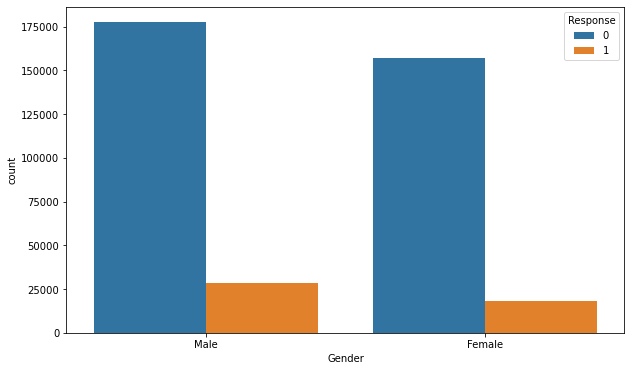

In [7]:
response=df['Response']
gender=df['Gender']
fig,ax=plt.subplots(figsize=(10,6))
sns.countplot(x=gender,hue=response);

In [8]:
gender.value_counts()

Male      206089
Female    175020
Name: Gender, dtype: int64

One Hot Encoding

In [9]:
gender_label = pd.get_dummies(df['Gender'],prefix='Gender')
gender_label

Gender_Female  Gender_Male
0                   0            1
1                   0            1
2                   0            1
3                   0            1
4                   1            0
...               ...          ...
381104              0            1
381105              0            1
381106              0            1
381107              1            0
381108              0            1

[381109 rows x 2 columns]

- **The difference between male and female number are not too big**
- **Change Gender data to label**

### Vehicle Age

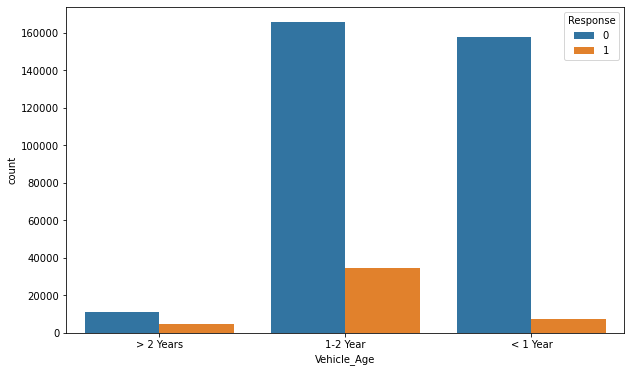

In [10]:
response=df['Response']
vehicle_age=df['Vehicle_Age']
fig,ax=plt.subplots(figsize=(10,6))
sns.countplot(x=vehicle_age,hue=response);

In [11]:
Vehicle_Age_Label=[]

for index,column in df.iterrows():
    if column['Vehicle_Age'] == '> 2 Years':
        y = 2
    elif column['Vehicle_Age'] == '< 1 Year':
        y = 0
    else:
        y = 1
    Vehicle_Age_Label.append(y)

In [12]:
len(Vehicle_Age_Label)

381109

- **There is a big difference between > 2 Years vehicle age and the others**
- **Change Vehicle Age data to label**

### Vehicle Damage

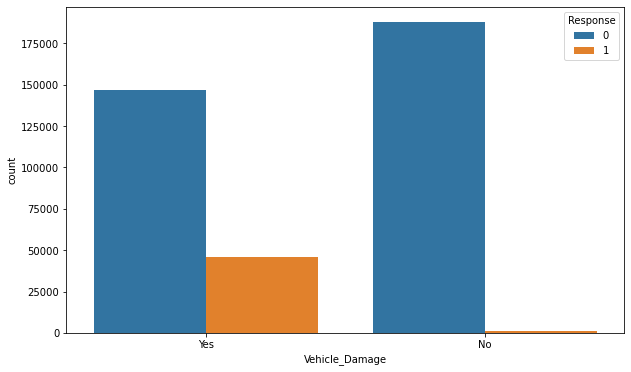

In [13]:
vehicle_damage = df['Vehicle_Damage']
fig,ax=plt.subplots(figsize=(10,6))
sns.countplot(x=vehicle_damage,hue=response);

In [14]:
vehicle_damage.value_counts()

Yes    192413
No     188696
Name: Vehicle_Damage, dtype: int64

In [15]:
vehicle_damage_label=df['Vehicle_Damage'].astype('category').cat.codes

- **The difference between yes and no number are not too big**
- **However, most of the customer who are interested have a damaged vehicle**
- **Change vehicle damage data to label**

In [16]:
df1=df.join(gender_label)
df1['Vehicle_Age_Label'] = Vehicle_Age_Label
df1['Vehicle_Damage_Label'] = vehicle_damage_label

In [17]:
df1.sample(5)

id  Gender  Age  Driving_License  Region_Code  Previously_Insured  \
183531  183532  Female   31                1         28.0                   0   
45376    45377  Female   37                1          3.0                   1   
140561  140562    Male   52                1         28.0                   0   
71423    71424  Female   22                1         30.0                   1   
61373    61374    Male   56                1          8.0                   0   

       Vehicle_Age Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  \
183531    1-2 Year            Yes         29887.0                 124.0   
45376     1-2 Year             No         33128.0                  26.0   
140561    1-2 Year            Yes         40264.0                  26.0   
71423     < 1 Year             No         18846.0                 152.0   
61373     1-2 Year            Yes         44237.0                  26.0   

        Vintage  Response  Gender_Female  Gender_Male  Vehicle_Age_Label  \
183531      261         0              1            0                  1   
45376       218         0              1            0                  1   
140561       94         0              0            1                  1   
71423       296         0              1            0                  0   
61373       179         0              0            1                  1   

        Vehicle_Damage_Label  
183531                     1  
45376                      0  
140561                     1  
71423                      0  
61373                      1

## Numerical Data

### Age

In [18]:
df['Vintage'].describe()

count    381109.000000
mean        154.347397
std          83.671304
min          10.000000
25%          82.000000
50%         154.000000
75%         227.000000
max         299.000000
Name: Vintage, dtype: float64

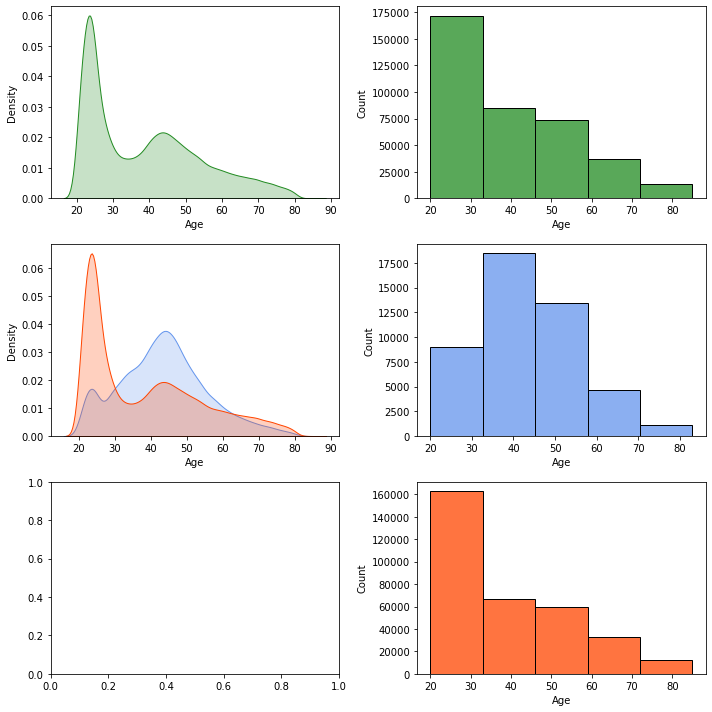

In [19]:
yes = df[response==1]
no = df[response==0]
fig,ax=plt.subplots(3,2,figsize=(10,10))
sns.kdeplot(x=df['Age'],color='forestgreen',shade=True,ax=ax[0,0])
#sns.histplot(x=df['Age'],color='green',ax=ax[0])
sns.kdeplot(x=yes['Age'],color='cornflowerblue',label='Yes',shade=True,ax=ax[1,0])
sns.kdeplot(x=no['Age'],color='orangered',label='No',shade=True,ax=ax[1,0])
sns.histplot(x=df['Age'],color='forestgreen',ax=ax[0,1],bins=5)
sns.histplot(x=yes['Age'],color='cornflowerblue',ax=ax[1,1],bins=5)
sns.histplot(x=no['Age'],color='orangered',ax=ax[2,1],bins=5)
plt.tight_layout();
#sns.kdeplot(x=no['Age'],color='red',label='No',ax=ax[1])

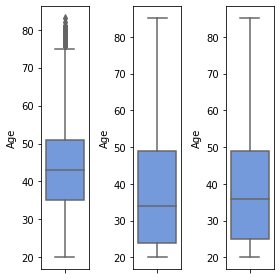

In [20]:
fig,ax=plt.subplots(1,3,figsize=(4,4))
sns.boxplot(y=yes['Age'],ax=ax[0],color='cornflowerblue')
sns.boxplot(y=no['Age'],ax=ax[1],color='cornflowerblue')
sns.boxplot(y=df['Age'],ax=ax[2],color='cornflowerblue')
plt.tight_layout()

In [21]:
print(len(df[df['Age'] <=35]))
print(len(df[(df['Age']>35) & (df['Age']<=60)]))
print(len(df[(df['Age']>60) & (df['Age']<=85)]))

186812
151058
43239


In [22]:
age_label=[]
for index,column in df1.iterrows():
    if column['Age'] <=35:
        w=0
    elif (column['Age'] > 35) & (column['Age'] <= 60):
        w=2
    else:
        w=1
    age_label.append(w)

In [23]:
df1['Age_Label']=age_label

- **The data is skewed**
- **classify the age into several age range would be better for machine learning model**

### Driving License

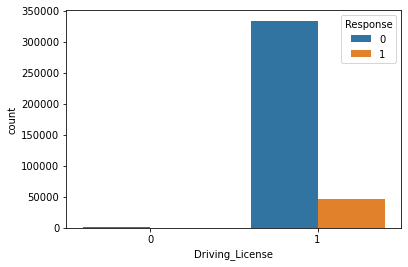

In [24]:
driving_license=df['Driving_License']
sns.countplot(x=driving_license,hue=response);

In [25]:
print('Overall')
print(driving_license.value_counts())
print()
print('Yes')
print(yes['Driving_License'].value_counts())
print()
print('No')
no['Driving_License'].value_counts()

Overall
1    380297
0       812
Name: Driving_License, dtype: int64

Yes
1    46669
0       41
Name: Driving_License, dtype: int64

No


1    333628
0       771
Name: Driving_License, dtype: int64

- **Most of the customer have a driving license, this column probably unimportant**
- **Need to reconsider this feature after check the evaluation metric of machine learning**

### Region_Code

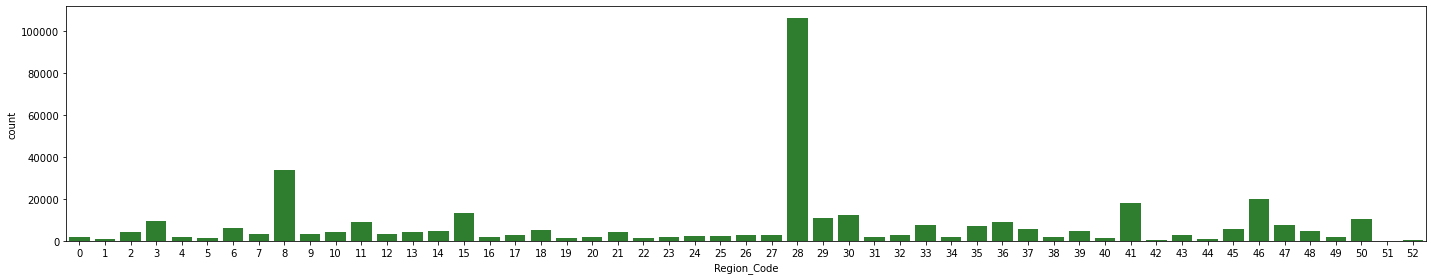

In [26]:
region_code=df['Region_Code']
fig,ax=plt.subplots(figsize=(20,4))
sns.countplot(x=region_code.astype(int),color='forestgreen')
plt.tight_layout();
#sns.distplot(yes['Region_Code'],ax=ax[1])
#sns.distplot(no['Region_Code'],ax=ax[1])

- **The customer distribution is concentrated only in few region**
- **Classify into small group probably necessary**

### Previously Insured

<AxesSubplot:xlabel='Previously_Insured', ylabel='count'>

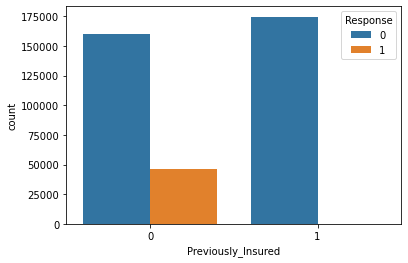

In [27]:
previously_insured=df['Previously_Insured']
sns.countplot(x=previously_insured,hue=response)

- **Most of the customer who are interested in using car insurance don't have it yet**

### Annual Premium

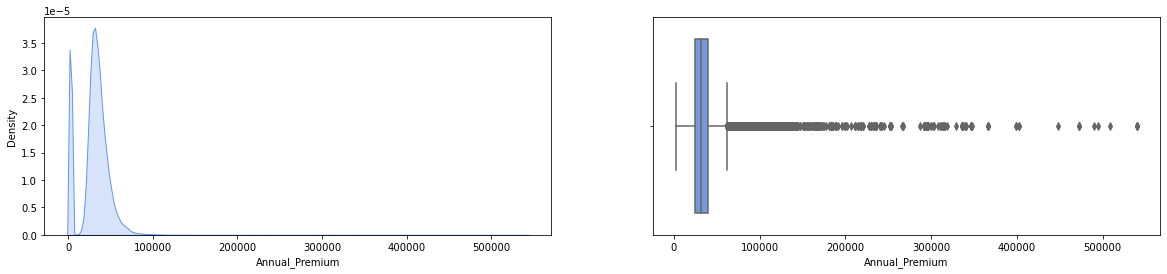

In [28]:
annual_premium=df['Annual_Premium']
fig,ax=plt.subplots(1,2,figsize=(20,4))
sns.kdeplot(x=annual_premium,ax=ax[0],color='cornflowerblue',shade=True)
sns.boxplot(x=annual_premium,ax=ax[1],color='cornflowerblue');

In [29]:
nums=['Annual_Premium']

In [30]:
print(f'Jumlah baris sebelum memfilter outlier: {len(df1)}')

filtered_entries = np.array([True] * len(df1))
for col in nums:
    Q1 = df1[col].quantile(0.25)
    Q3 = df1[col].quantile(0.75)
    IQR = Q3 - Q1
    low_limit = Q1 - (IQR * 1.5)
    high_limit = Q3 + (IQR * 1.5)

    filtered_entries = ((df1[col] >= low_limit) & (df1[col] <= high_limit)) & filtered_entries
    
df2 = df1[filtered_entries]

print(f'Jumlah baris setelah memfilter outlier: {len(df2)}')

Jumlah baris sebelum memfilter outlier: 381109
Jumlah baris setelah memfilter outlier: 370789


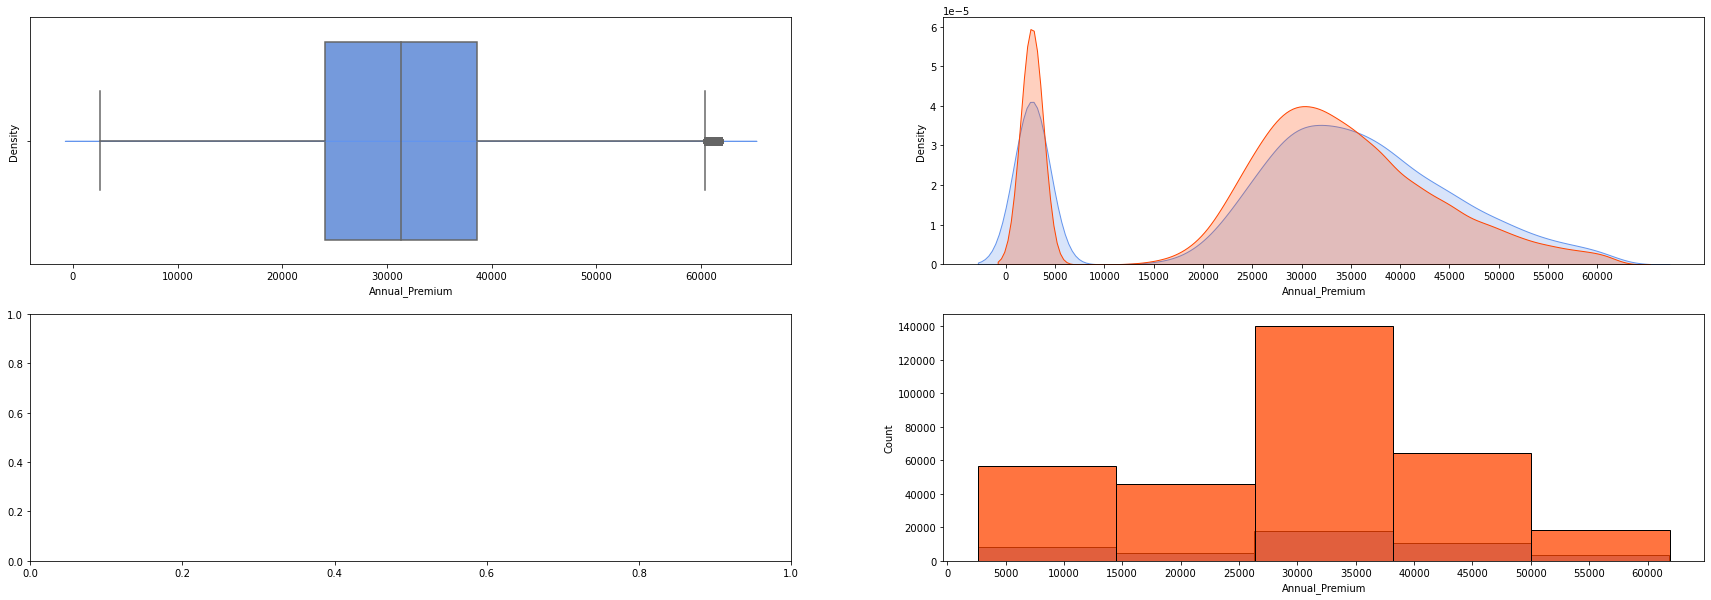

In [31]:
annual_premium2=df2['Annual_Premium']
yes2=df2[df2['Response']==1]
no2=df2[df2['Response']==0]
fig,ax=plt.subplots(2,2,figsize=(30,10))
sns.kdeplot(annual_premium2,ax=ax[0,0],color='cornflowerblue',shade=True)
sns.boxplot(x=annual_premium2,ax=ax[0,0],color='cornflowerblue')
sns.kdeplot(yes2['Annual_Premium'],ax=ax[0,1],color='cornflowerblue',label='yes',shade=True)
sns.kdeplot(no2['Annual_Premium'],ax=ax[0,1],color='orangered',label='no',shade=True)
sns.histplot(yes2['Annual_Premium'],ax=ax[1,1],bins=5,color='cornflowerblue')
sns.histplot(no2['Annual_Premium'],ax=ax[1,1],bins=5,color='orangered')
ax[1,1].set_xticks(range(0,62000,5000))
ax[0,1].set_xticks(range(0,62000,5000))
plt.tight_layout;

In [32]:
df2['Annual_Premium'].describe()

count    370789.000000
mean      29264.643973
std       14743.056656
min        2630.000000
25%       24102.000000
50%       31319.000000
75%       38596.000000
max       61892.000000
Name: Annual_Premium, dtype: float64

In [33]:
print(len(df2[df2['Annual_Premium'] <=15000]))
print(len(df2[(df2['Annual_Premium']>15000) & (df2['Annual_Premium']<=22000)]))
print(len(df2[(df2['Annual_Premium']>22000) & (df2['Annual_Premium']<=39000)]))
print(len(df2[(df2['Annual_Premium']>39000) & (df2['Annual_Premium']<=50000)]))
print(len(df2[(df2['Annual_Premium']>50000) & (df2['Annual_Premium']<=62000)]))

65267
13000
203871
66767
21884


In [34]:
c=df2['Annual_Premium'].astype('int').reset_index()
c.head()

index  Annual_Premium
0      0           40454
1      1           33536
2      2           38294
3      3           28619
4      4           27496

In [35]:
annual_premium_label1=[]
for index,column in c.iterrows():
    if column['Annual_Premium'] <= 15000:
        w=3
    elif (column['Annual_Premium'] > 15000) & (column['Annual_Premium'] <= 22000):
        w=2
    elif (column['Annual_Premium'] > 22000) & (column['Annual_Premium'] <= 39000):
        w=0
    elif (column['Annual_Premium'] > 39000) & (column['Annual_Premium'] <= 50000):
        w=1
    else:
        w=4
    annual_premium_label1.append(w)

In [36]:
df3=df2.copy()
df3['Annual_Premium_Label']=annual_premium_label1

In [37]:
annual_premium_label_onehot=pd.get_dummies(df3['Annual_Premium_Label'],prefix='Annual_Premium')
annual_premium_label_onehot

Annual_Premium_0  Annual_Premium_1  Annual_Premium_2  \
0                      0                 1                 0   
1                      1                 0                 0   
2                      1                 0                 0   
3                      1                 0                 0   
4                      1                 0                 0   
...                  ...               ...               ...   
381104                 1                 0                 0   
381105                 0                 1                 0   
381106                 1                 0                 0   
381107                 0                 1                 0   
381108                 0                 1                 0   

        Annual_Premium_3  Annual_Premium_4  
0                      0                 0  
1                      0                 0  
2                      0                 0  
3                      0                 0  
4                      0                 0  
...                  ...               ...  
381104                 0                 0  
381105                 0                 0  
381106                 0                 0  
381107                 0                 0  
381108                 0                 0  

[370789 rows x 5 columns]

In [38]:
df3=df3.join(annual_premium_label_onehot)

In [39]:
df

id  Gender  Age  Driving_License  Region_Code  Previously_Insured  \
0            1    Male   44                1         28.0                   0   
1            2    Male   76                1          3.0                   0   
2            3    Male   47                1         28.0                   0   
3            4    Male   21                1         11.0                   1   
4            5  Female   29                1         41.0                   1   
...        ...     ...  ...              ...          ...                 ...   
381104  381105    Male   74                1         26.0                   1   
381105  381106    Male   30                1         37.0                   1   
381106  381107    Male   21                1         30.0                   1   
381107  381108  Female   68                1         14.0                   0   
381108  381109    Male   46                1         29.0                   0   

       Vehicle_Age Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  \
0        > 2 Years            Yes         40454.0                  26.0   
1         1-2 Year             No         33536.0                  26.0   
2        > 2 Years            Yes         38294.0                  26.0   
3         < 1 Year             No         28619.0                 152.0   
4         < 1 Year             No         27496.0                 152.0   
...            ...            ...             ...                   ...   
381104    1-2 Year             No         30170.0                  26.0   
381105    < 1 Year             No         40016.0                 152.0   
381106    < 1 Year             No         35118.0                 160.0   
381107   > 2 Years            Yes         44617.0                 124.0   
381108    1-2 Year             No         41777.0                  26.0   

        Vintage  Response  
0           217         1  
1           183         0  
2            27         1  
3           203         0  
4            39         0  
...         ...       ...  
381104       88         0  
381105      131         0  
381106      161         0  
381107       74         0  
381108      237         0  

[381109 rows x 12 columns]

- **Annual Premium has many outlier, need to remove the outlier using IQR method**
- **After remove the outlier, the distribution still skewed**
- **Normalize the data will not give any impact to the machine learning model (already tried), classify the annual premium into several group would be better**
- **One hots encoding to try it in Machine Learning model just in case the evaluation metric is not so good**

### Policy Sales Channel

In [40]:
df['Policy_Sales_Channel'].describe()

count    381109.000000
mean        112.034295
std          54.203995
min           1.000000
25%          29.000000
50%         133.000000
75%         152.000000
max         163.000000
Name: Policy_Sales_Channel, dtype: float64

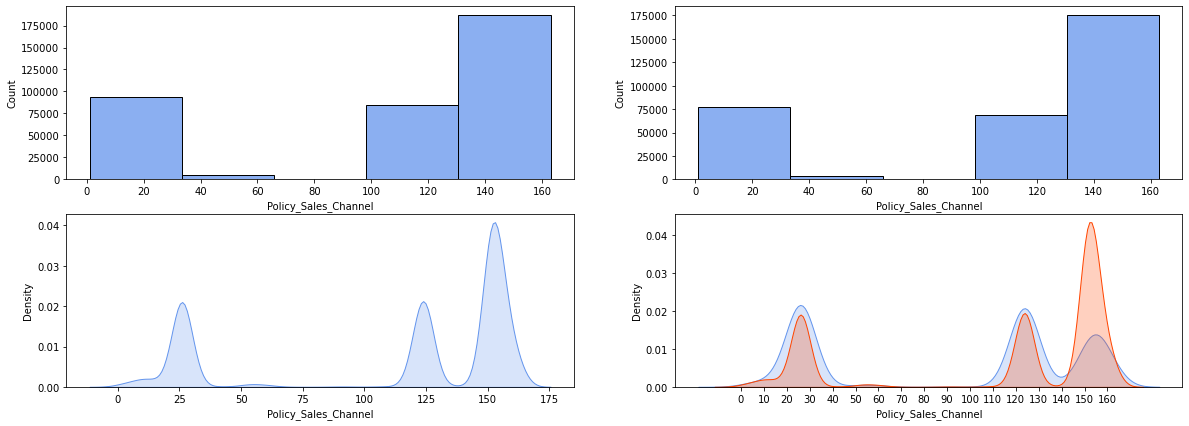

In [41]:
policy_sales_channel=df3['Policy_Sales_Channel']
fig,ax=plt.subplots(2,2,figsize=(20,7))
sns.histplot(x=policy_sales_channel,ax=ax[0,0],bins=5,color='cornflowerblue')
sns.histplot(x=no2['Policy_Sales_Channel'],ax=ax[0,1],color='cornflowerblue',bins=5)
sns.kdeplot(x=policy_sales_channel,ax=ax[1,0],color='cornflowerblue',shade=True)
sns.kdeplot(x=yes2['Policy_Sales_Channel'],ax=ax[1,1],color='cornflowerblue',shade=True)
sns.kdeplot(x=no2['Policy_Sales_Channel'],ax=ax[1,1],color='orangered',shade=True)
ax[1,1].set_xticks(range(0,170,10));
#sns.kdeplot(x=no2['Policy_Sales_Channel'],ax=ax[1],color='red');

In [42]:
df3['Policy_Sales_Channel'].describe()

count    370789.000000
mean        112.542923
std          54.039616
min           1.000000
25%          30.000000
50%         151.000000
75%         152.000000
max         163.000000
Name: Policy_Sales_Channel, dtype: float64

In [43]:
print(len(df3[df3['Policy_Sales_Channel'] <=40]))
print(len(df3[(df3['Policy_Sales_Channel']>105) & (df3['Policy_Sales_Channel']<=135)]))
print(len(df3[(df3['Policy_Sales_Channel']>135) & (df3['Policy_Sales_Channel']<=170)]))

94493
84489
187064


In [44]:
d=df3['Policy_Sales_Channel'].astype('int').reset_index()
d.head()

index  Policy_Sales_Channel
0      0                    26
1      1                    26
2      2                    26
3      3                   152
4      4                   152

In [45]:
policy_sales_channel_label=[]
for index,column in d.iterrows():
    if column['Policy_Sales_Channel'] <= 40:
        w=3
    elif (column['Policy_Sales_Channel'] > 105) & (column['Policy_Sales_Channel'] <= 135):
        w=2
    elif (column['Policy_Sales_Channel'] > 135) & (column['Policy_Sales_Channel'] <= 170):
        w=0
    else:
        w=1
    policy_sales_channel_label.append(w)

In [46]:
df3['policy_sales_channel_label']=policy_sales_channel_label

- **Same with region code, policy sales channel is concentrated in several point**
- **Classify the data into small group based on customer intention towards vehicle insurance**

### Vintage

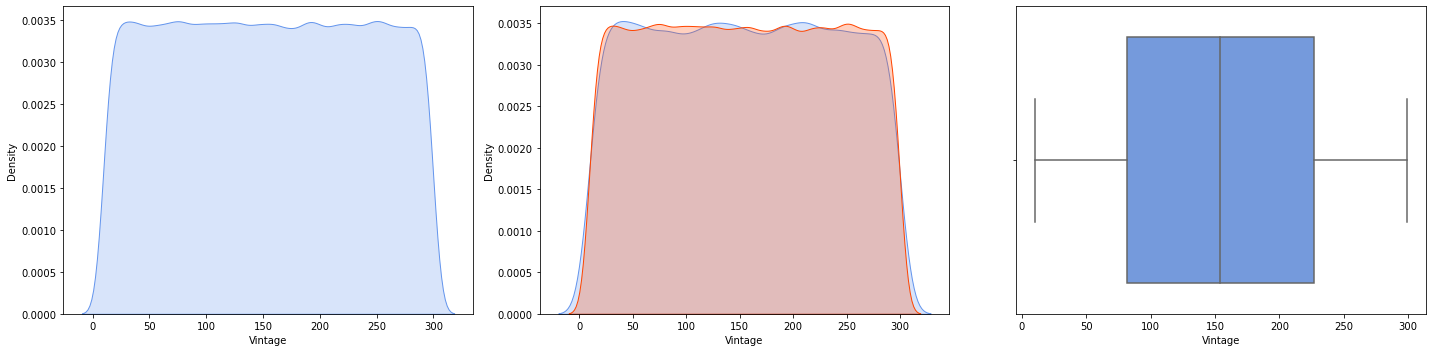

In [47]:
yes2=df3[df3['Response']==1]
no2=df3[df3['Response']==0]
vintage=df3['Vintage']
fig,ax=plt.subplots(1,3,figsize=(20,5))
sns.kdeplot(vintage,ax=ax[0],color='cornflowerblue',shade=True)
sns.kdeplot(yes2['Vintage'],ax=ax[1],color='cornflowerblue',label='yes',shade=True)
sns.kdeplot(no2['Vintage'],ax=ax[1],color='orangered',label='no',shade=True)
sns.boxplot(x=vintage,ax=ax[2],color='cornflowerblue')
plt.tight_layout();

In [48]:
vintage.value_counts()

256    1382
73     1375
282    1361
126    1355
158    1354
       ... 
224    1204
89     1201
205    1198
32     1194
277    1179
Name: Vintage, Length: 290, dtype: int64

In [49]:
df3['Vintage'].describe()

count    370789.000000
mean        154.345442
std          83.670478
min          10.000000
25%          82.000000
50%         154.000000
75%         227.000000
max         299.000000
Name: Vintage, dtype: float64

In [50]:
vintage_by_month=[]
for index,column in df3.iterrows():
    y=round(column['Vintage']/30)
    vintage_by_month.append(y)

In [51]:
df3['vintage_by_month_round']=vintage_by_month

- **Vintage data represent the number of days customer has been associated with the company**
- **Transform the data into month (vintage data/30)**
- **Overall, the data is range between 1-10 which is easier for machine learning model to train**

# Business Insight & Recommendation

**In this part, the business insight will given based on the health insurance customer data. Hopefully this business insight can help the sales agent to improve their performance related with the cross-selling strategy**

## Potential Customer

In [52]:
response_label=[]

for index, column in df.iterrows():
    if column['Response'] == 1:
        b='interested'
    else:
        b='not interested'
    response_label.append(b)
df['response_label']=response_label

In [53]:
driving_license_label=[]

for index, column in df.iterrows():
    if column['Driving_License'] == 1:
        b='yes'
    else:
        b='no'
    driving_license_label.append(b)
df['Driving_license']=driving_license_label

In [54]:
previously_insured_label=[]

for index, column in df.iterrows():
    if column['Previously_Insured'] == 1:
        b='yes'
    else:
        b='no'
    previously_insured_label.append(b)
df['Previously_insured']=previously_insured_label

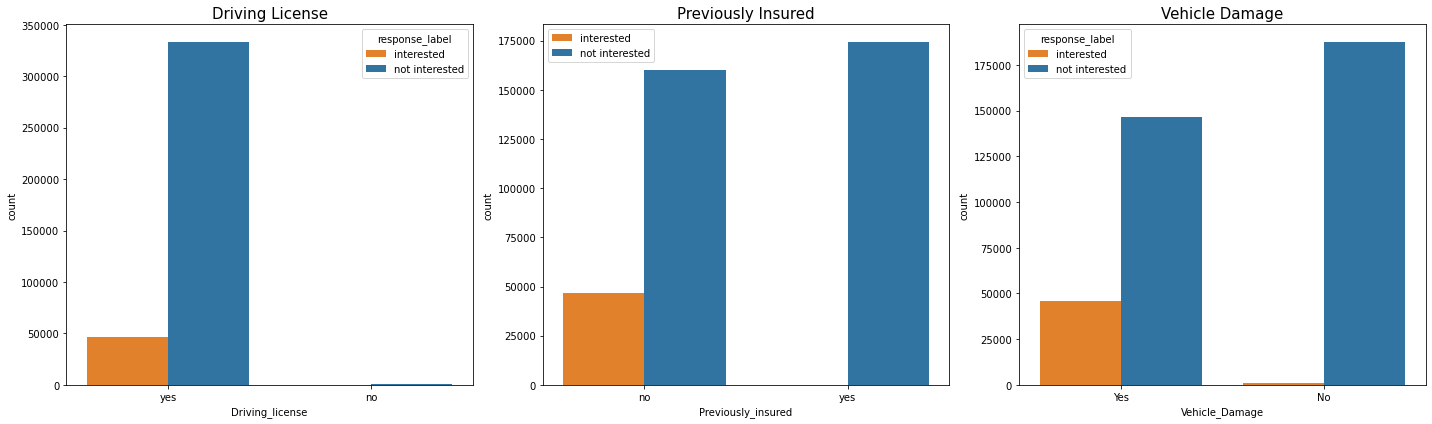

In [55]:
palette={'not interested':'C0','interested':'C1'}
fix,ax=plt.subplots(1,3,figsize=(20,6))
sns.countplot(x=df['Driving_license'],ax=ax[0],hue=df['response_label'],palette=palette)
ax[0].set_title('Driving License',fontsize=15)
sns.countplot(x=df['Previously_insured'],ax=ax[1],hue=df['response_label'],palette=palette)
ax[1].set_title('Previously Insured',fontsize=15)
ax[1].legend(loc=0)
sns.countplot(x=df['Vehicle_Damage'],ax=ax[2],hue=df['response_label'],palette=palette)
ax[2].set_title('Vehicle Damage',fontsize=15)
plt.tight_layout();

## Priority Customer

### Vehicle Age

In [56]:
yes3=df3[df3['Response']==1]
no3=df3[df3['Response']==0]

In [57]:
print('overall')
print(vehicle_age.value_counts())
print()
print('Yes')
print(yes3['Vehicle_Age'].value_counts())
print()
print('No')
print(no3['Vehicle_Age'].value_counts())

overall
1-2 Year     200316
< 1 Year     164786
> 2 Years     16007
Name: Vehicle_Age, dtype: int64

Yes
1-2 Year     33745
< 1 Year      7060
> 2 Years     4350
Name: Vehicle_Age, dtype: int64

No
1-2 Year     160467
< 1 Year     154487
> 2 Years     10680
Name: Vehicle_Age, dtype: int64


In [58]:
print(4350/(16007))
print(33745/200316)
print(7060/164786)

0.2717561067033173
0.1684588350406358
0.04284344543832607


In [59]:
text='''

Around 30% of customer
with > 2 Years vehicle
age are interested to
use vehicle insurance.

'''

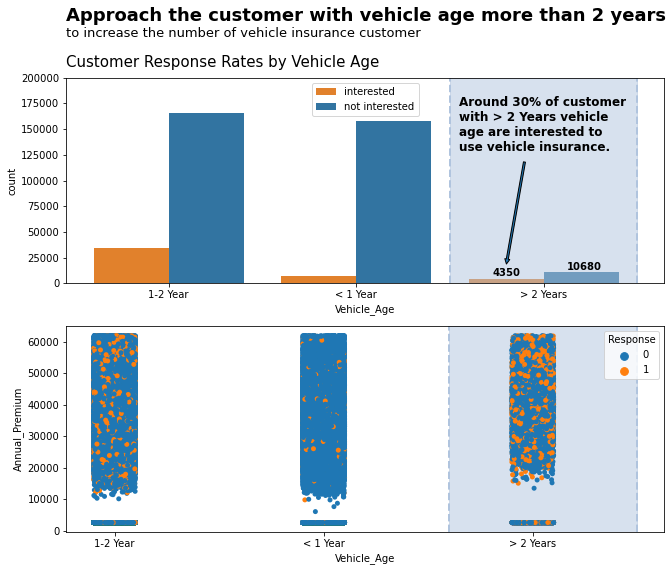

In [60]:
fig,ax=plt.subplots(2,1,figsize=(10,8))
sns.countplot(x=df['Vehicle_Age'].sort_values(),ax=ax[0],hue=df['response_label'],palette=palette)
ax[0].legend()
ax[0].axvline(1.5,color='lightsteelblue',linestyle='--',linewidth=2)
ax[0].axvline(2.5,color='lightsteelblue',linestyle='--',linewidth=2)
ax[0].axvspan(1.5,2.5,color='lightsteelblue',alpha=0.5)
ax[0].text(x=1.55,y=100000,s=text,fontweight='bold',horizontalalignment='left',fontsize=12)
ax[0].set_ylim(0,200000)
ax[0].text(2.125,13000,s='10680',fontweight='bold')
ax[0].text(1.725,7000,s='4350',fontweight='bold')
ax[0].annotate(xy=(1.8,17000),xytext=(1.9,120000),text='',
              arrowprops=dict(ec='black',
                             arrowstyle='simple'))
ax[0].text(-0.55,255000,s='Approach the customer with vehicle age more than 2 years',fontsize=18,fontweight='bold')
ax[0].text(-0.55,240000,s='to increase the number of vehicle insurance customer',fontsize=13)
ax[0].text(-0.55,210000,s='Customer Response Rates by Vehicle Age',fontsize=15)

sns.stripplot(x=df3['Vehicle_Age'].sort_values(),y=df3['Annual_Premium'],ax=ax[1],hue=response)
ax[1].axvline(1.6,color='lightsteelblue',linestyle='--',linewidth=2)
ax[1].axvline(2.5,color='lightsteelblue',linestyle='--',linewidth=2)
ax[1].axvspan(1.6,2.5,color='lightsteelblue',alpha=0.5)
plt.tight_layout();

### Age

In [61]:
text='''
Customers over 30 tend to
be more interested in using
vehicle insurance
'''
text2='''
Around
30
'''

text3='''
Around
63
'''

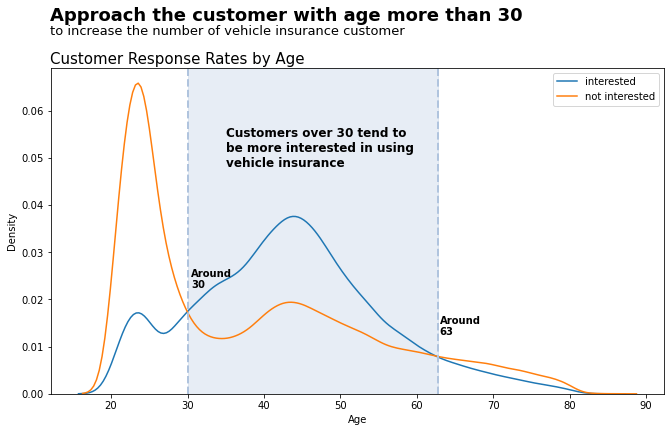

In [62]:
fig,ax=plt.subplots(1,1,figsize=(11,6))
sns.kdeplot(x=yes3['Age'],label='interested',color='C0')
sns.kdeplot(x=no3['Age'],label='not interested',color='C1')
plt.axvline(x=30,color='lightsteelblue',linestyle='--',linewidth=2)
plt.axvline(x=62.8,color='lightsteelblue',linestyle='--',linewidth=2)
plt.axvspan(30,62.8,color='lightsteelblue',alpha=0.3)
plt.text(x=35,y=0.045,s=text,fontweight='bold',fontsize=12)
plt.text(x=30.5,y=0.02,s=text2,fontweight='bold')
plt.text(x=63,y=0.01,s=text3,fontweight='bold')
plt.legend()
#plt.annotate(xy=(30.5,0.02),xytext=(40,0.047),text='',
 #           arrowprops=dict(ec='black',
  #                         arrowstyle='simple'))

plt.text(12,0.079,s='Approach the customer with age more than 30',fontsize=18,fontweight='bold')
plt.text(12,0.076,s='to increase the number of vehicle insurance customer',fontsize=13)
plt.text(12,0.07,s='Customer Response Rates by Age',fontsize=15);

### Policy Sales Channel

In [63]:
psc=yes3.groupby('Policy_Sales_Channel').count().reset_index()
psc_yes=psc.sort_values('Policy_Sales_Channel',ascending=True)[['Policy_Sales_Channel','id']]
psc_no=no3.groupby('Policy_Sales_Channel').count().reset_index().sort_values('Policy_Sales_Channel',ascending=True)
psc_percentage=psc_yes.merge(psc_no,
                            left_on='Policy_Sales_Channel',
                            right_on='Policy_Sales_Channel',
                            how='left')
psc_percentage=psc_percentage[['Policy_Sales_Channel','id_x','id_y']]
psc_percentage['percentage']=round((psc_percentage['id_x']/(psc_percentage['id_x']+psc_percentage['id_y']))*100)
psc_priority=psc_percentage.sort_values('percentage',ascending=False).head(8)
psc_priority

Policy_Sales_Channel  id_x    id_y  percentage
25                   28.0     1     2.0        33.0
24                   27.0     1     2.0        33.0
60                   80.0     4     8.0        33.0
112                 155.0   388   820.0        32.0
87                  121.0    19    43.0        31.0
31                   36.0    15    34.0        31.0
118                 163.0   867  1989.0        30.0
2                     3.0   145   341.0        30.0

### Region Code

In [64]:
region_code_yes=yes3.groupby('Region_Code').count().reset_index()[['Region_Code','id']]
region_code_no=no3.groupby('Region_Code').count().reset_index()[['Region_Code','id']]
region_code_yes['no']=region_code_no['id']
region_code_merge=region_code_yes.rename(columns={'id':'yes'})
region_code_merge['Percentage']=round((region_code_merge['yes']/(region_code_merge['yes']+region_code_merge['no']))*100)
best_region=region_code_merge.sort_values('Percentage',ascending=False).reset_index().head(6)
best_region

index  Region_Code    yes     no  Percentage
0     28         28.0  18704  81037        19.0
1     38         38.0    386   1620        19.0
2      4          4.0    283   1513        16.0
3     19         19.0    250   1284        16.0
4     51         51.0     26    148        15.0
5     23         23.0    299   1659        15.0

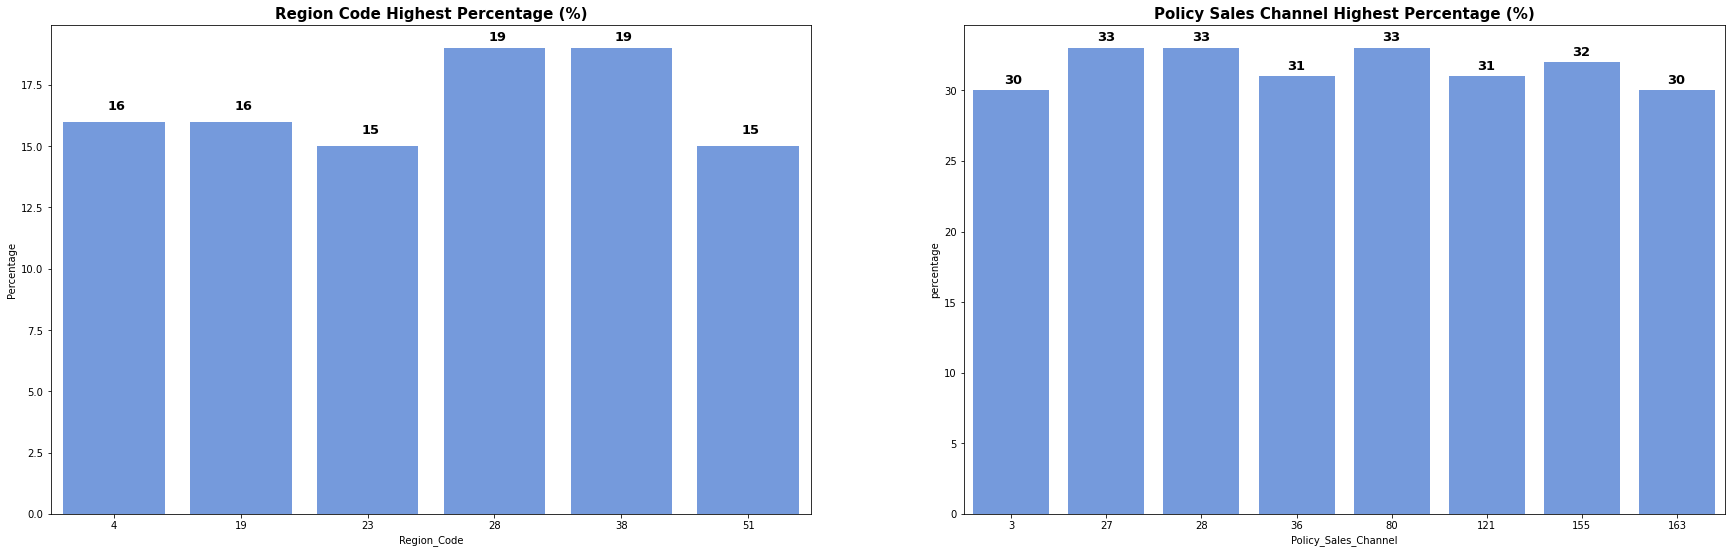

In [65]:
fig,ax=plt.subplots(1,2,figsize=(30,9))

sns.barplot(x=best_region['Region_Code'].astype(int),y=best_region['Percentage'],color='cornflowerblue',ax=ax[0])
ax[0].text(x=-0.05,y=16.5,s='16',fontweight='bold',fontsize=13)
ax[0].text(x=-0.05+1,y=16.5,s='16',fontweight='bold',fontsize=13)
ax[0].text(x=-0.05+2,y=15.5,s='15',fontweight='bold',fontsize=13)
ax[0].text(x=-0.05+5,y=15.5,s='15',fontweight='bold',fontsize=13)
ax[0].text(x=-0.05+3,y=19.3,s='19',fontweight='bold',fontsize=13)
ax[0].text(x=-0.05+4,y=19.3,s='19',fontweight='bold',fontsize=13)
ax[0].set_title('Region Code Highest Percentage (%)',fontsize=15,fontweight='bold')

sns.barplot(x=psc_priority['Policy_Sales_Channel'].astype(int),y=psc_priority['percentage'],color='cornflowerblue',ax=ax[1])
ax[1].set_title('Policy Sales Channel Highest Percentage (%)',fontsize=15,fontweight='bold')
ax[1].text(x=-0.07,y=30.5,s='30',fontweight='bold',fontsize=13)
ax[1].text(x=0.05+0.85,y=33.5,s='33',fontweight='bold',fontsize=13)
ax[1].text(x=0.05+1.85,y=33.5,s='33',fontweight='bold',fontsize=13)
ax[1].text(x=0.05+2.85,y=31.5,s='31',fontweight='bold',fontsize=13)
ax[1].text(x=0.05+3.85,y=33.5,s='33',fontweight='bold',fontsize=13)
ax[1].text(x=0.05+4.85,y=31.5,s='31',fontweight='bold',fontsize=13)
ax[1].text(x=0.05+5.85,y=32.5,s='32',fontweight='bold',fontsize=13)
ax[1].text(x=0.05+6.85,y=30.5,s='30',fontweight='bold',fontsize=13);

### Total number of Priority Customer

In [66]:
potcus = df[
    ((df['Age'] >= 30) & (df['Age'] <= 63)) &
    (df['Driving_License'] == 1) &
    (df['Previously_Insured'] == 0) &
    (df['Vehicle_Age'].isin(['1-2 Year', '> 2 Years'])) &
    (df['Vehicle_Damage'] == 'Yes') &
    (df['Region_Code'].isin([38.0,28.0,19.0,4.0,23.0,51.0]))]

In [67]:
not_filtered_all = df.shape[0]
not_filtered_yes = df[df['Response']==1].shape[0]
not_filtered_no = df[df['Response']==0].shape[0]
filtered_all = potcus.shape[0]
filtered_yes = potcus[potcus['Response']==1].shape[0]
filtered_no = potcus[potcus['Response']==0].shape[0]
percent_not_filtered = round((not_filtered_yes/not_filtered_all)*100,2)
percent_filtered = round((filtered_yes/filtered_all)*100,2)
print("Number of all customers before filtering: " + str(not_filtered_all))
print("Number of all customers responding yes before filtering: " + str(not_filtered_yes))
print("Number of all customers responding no before filtering: " + str(not_filtered_no))
print("Number of potential customers after filtering (priority customer): " + str(filtered_all))
print("Number of potential customers responding yes after filtering (priority customer): " + str(filtered_yes))
print("Number of potential customers responding no after filtering (priority customer): " + str(filtered_no))

Number of all customers before filtering: 381109
Number of all customers responding yes before filtering: 46710
Number of all customers responding no before filtering: 334399
Number of potential customers after filtering (priority customer): 52717
Number of potential customers responding yes after filtering (priority customer): 16837
Number of potential customers responding no after filtering (priority customer): 35880


### Total number of Non-Priority Customer (Basic)

In [68]:
potcus = df[
    (df['Age'] < 30) &
    (df['Driving_License'] == 1) &
    (df['Previously_Insured'] == 0) &
    ~(df['Vehicle_Age'].isin(['1-2 Year', '> 2 Years'])) &
    (df['Vehicle_Damage'] == 'Yes') &
    ~(df['Region_Code'].isin([38.0,28.0,19.0,4.0,23.0,51.0]))]

In [69]:
not_filtered_all = df.shape[0]
not_filtered_yes = df[df['Response']==1].shape[0]
not_filtered_no = df[df['Response']==0].shape[0]
filtered_all = potcus.shape[0]
filtered_yes = potcus[potcus['Response']==1].shape[0]
filtered_no = potcus[potcus['Response']==0].shape[0]
percent_not_filtered = round((not_filtered_yes/not_filtered_all)*100,2)
percent_filtered = round((filtered_yes/filtered_all)*100,2)
print("Number of all customers before filtering: " + str(not_filtered_all))
print("Number of all customers responding yes before filtering: " + str(not_filtered_yes))
print("Number of all customers responding no before filtering: " + str(not_filtered_no))
print("Number of potential customers after filtering (basic customer): " + str(filtered_all))
print("Number of potential customers responding yes after filtering (basic customer): " + str(filtered_yes))
print("Number of potential customers responding no after filtering (basic customer): " + str(filtered_no))

Number of all customers before filtering: 381109
Number of all customers responding yes before filtering: 46710
Number of all customers responding no before filtering: 334399
Number of potential customers after filtering (basic customer): 33016
Number of potential customers responding yes after filtering (basic customer): 3652
Number of potential customers responding no after filtering (basic customer): 29364


## **There are several points that we can conclude from the data:**

**from not-interested customers (334339), turns out that there are some customers who, in our opinion, have the potential to provide more revenue for the company. We classify these potential customers into two groups, priority and non-priority (basic) customers:**

## **Potential Customer**
- Basically, vehicle insurance potential customer are customer who has **driving license**, **previously has insured**, and has experienced **vehicle damage.**

## **Priority Customer**

### Age
- Prioritize customer with **age between 30-62**, because most of the customer who interested in vehicle insurance are come from that age range.
- Customer with age **below 30** are not really interested with vehicle insurance. However, since the number of customer in this age range is quite big, we need to **consider another strategy** to approach this age range. **Other vehicle insurance package with lower annual premium** perhaps will acceptable because this age range probably don't have big income. 

### Vehicle Age
- Prioritize customer with **vehicle age more than 2 years**, even though the number of interested in this category is not bigger than the other, the percentage is quite big. Around 30% of customer with vehicle age more than 2 years is interested in using vehicle insurance.
- Same approach strategy with age, **package with lower annual premium** perhaps can attract customer with vehicle age less than 2 years

### Region Code
- Overall, there are 6 region with **highest percentage, 4, 19, 23, 28, 38, and 51.**
- First, **focus on approaching customer in those region**, because the success rate is higher than the other region.
- After finish with those region, **approaching other region still necessary**. But, to make it more efficient, it would be better if machine learning model is used (will be discussed after this part).

### Policy Sales Channel
- Overall, there are 6 policy sales channel with **highest percentage, 3, 27, 38, 36, 80, 121, 155, and 163.**
- Sales agent is **recommended to use those channel** method since the success rate is higher compare with the other channel.

## **Recommendation**
- We will give some recommendation to sales team what should they do to approach the priority and basic customer.
1. Approach the customer gradually from priority to basic customer.
2. Approach the customer with different strategy for basic customer because this customer have different characteristic (lower salary and more fresh vehicle).
3. For priority customer, give them special treatment: free towing, maintenance discount and fuel discount.
4. Approach the customer using the best policy sales channel.

## **Business Impact**
- After knowing the criteria, We found there are **35880 priority customer** and **29364** non-priority customer or we named it **basic customer**
- We assume the revenue company got if they can reach one priority customer are **Rs.3000** and **Rs.1000** for basic customer
- If company can reach all of priority customer, the total revenue are **Rs. 108 million**, and **Rs. 29 million** for basic customer.
- So, the total revenue if company can reach all of potential customer are around **Rs. 137 million**, or can **increase the revenue by 97%**

**Nb: Detail explanation available in the final report**

# Modelling

In [70]:
df4=df3[['Age_Label','Driving_License','Region_Code','Previously_Insured','policy_sales_channel_label','vintage_by_month_round','Gender_Female','Gender_Male','Vehicle_Age_Label','Vehicle_Damage_Label','Annual_Premium_Label','Response']]
df4.sample(5)

Age_Label  Driving_License  Region_Code  Previously_Insured  \
284878          0                1         15.0                   1   
346795          0                1         12.0                   0   
22950           0                1         46.0                   1   
283032          0                1          8.0                   0   
5523            0                1         16.0                   1   

        policy_sales_channel_label  vintage_by_month_round  Gender_Female  \
284878                           3                       8              0   
346795                           0                       4              0   
22950                            0                       3              0   
283032                           0                       4              0   
5523                             0                       6              1   

        Gender_Male  Vehicle_Age_Label  Vehicle_Damage_Label  \
284878            1                  1                     0   
346795            1                  1                     1   
22950             1                  0                     0   
283032            1                  0                     1   
5523              0                  0                     1   

        Annual_Premium_Label  Response  
284878                     3         0  
346795                     3         1  
22950                      0         0  
283032                     4         0  
5523                       3         0

### Oversampling

In [71]:
x=df4.drop('Response',axis=1)
y=df4['Response']
print(x.shape)
print(y.shape)

(370789, 11)
(370789,)


In [72]:
x_over,y_over=over_sampling.RandomOverSampler().fit_resample(x,y)
print(pd.Series(y_over).value_counts())
train1=x_over
train1['Response']=y_over
train1.head()

1    325634
0    325634
Name: Response, dtype: int64


Age_Label  Driving_License  Region_Code  Previously_Insured  \
0          2                1         28.0                   0   
1          1                1          3.0                   0   
2          2                1         28.0                   0   
3          0                1         11.0                   1   
4          0                1         41.0                   1   

   policy_sales_channel_label  vintage_by_month_round  Gender_Female  \
0                           3                       7              0   
1                           3                       6              0   
2                           3                       1              0   
3                           0                       7              0   
4                           0                       1              1   

   Gender_Male  Vehicle_Age_Label  Vehicle_Damage_Label  Annual_Premium_Label  \
0            1                  2                     1                     1   
1            1                  1                     0                     0   
2            1                  2                     1                     0   
3            1                  0                     0                     0   
4            0                  0                     0                     0   

   Response  
0         1  
1         0  
2         1  
3         0  
4         0

### Split Train & Test Data

In [73]:
x=train1.drop(['Response'],axis=1)
y=train1['Response']
xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.3,random_state=42)

### Modelling

In [74]:
regressors = [LogisticRegression(max_iter=1000),
              XGBClassifier(eval_metric='auc',
                            use_label_encoder =False),
              AdaBoostClassifier(),
              KNeighborsClassifier(),
              RandomForestClassifier(),
              DecisionTreeClassifier()]

eval_test = pd.DataFrame(columns = ['Method','Accuracy', 'Precision', 'Recall', 'ROC-AUC'])
eval_train = pd.DataFrame(columns = ['Method','Accuracy', 'Precision', 'Recall', 'ROC-AUC'])

In [75]:
for regressor in regressors:
    regressor.fit(xtrain, ytrain)
    ypred = regressor.predict(xtest)
    
    method = str(type(regressor)).split('.')[-1][:-2]
    
    accuracy = accuracy_score(ytest, ypred)
    
    precision = precision_score(ytest, ypred)
    
    recall = recall_score(ytest, ypred)
    
    ROC_AUC = roc_auc_score(ytest,ypred)
    
    eval_test = eval_test.append({'Method': method, 
                    'Accuracy': accuracy, 
                    'Precision': precision,
                    'Recall': recall,
                    'ROC-AUC': ROC_AUC},
                     ignore_index=True)

In [76]:
eval_test

Method  Accuracy  Precision    Recall   ROC-AUC
0      LogisticRegression  0.785092   0.706540  0.976052  0.784883
1           XGBClassifier  0.802647   0.739427  0.935335  0.802502
2      AdaBoostClassifier  0.787016   0.711868  0.965142  0.786822
3    KNeighborsClassifier  0.790148   0.748469  0.874710  0.790056
4  RandomForestClassifier  0.832952   0.772033  0.945438  0.832829
5  DecisionTreeClassifier  0.831514   0.773355  0.938413  0.831397

In [77]:
for regressor in regressors:
    regressor.fit(xtrain, ytrain)
    ypred = regressor.predict(xtrain)
    
    method = str(type(regressor)).split('.')[-1][:-2]
    
    accuracy = accuracy_score(ytrain, ypred)
    
    precision = precision_score(ytrain, ypred)
    
    recall = recall_score(ytrain, ypred)
    
    ROC_AUC = roc_auc_score(ytrain,ypred)
    
    eval_train = eval_train.append({'Method': method, 
                    'Accuracy': accuracy, 
                    'Precision': precision,
                    'Recall': recall,
                    'ROC-AUC': ROC_AUC},
                     ignore_index=True)

In [78]:
eval_train

Method  Accuracy  Precision    Recall   ROC-AUC
0      LogisticRegression  0.784348   0.705658  0.975316  0.784437
1           XGBClassifier  0.803146   0.739220  0.936477  0.803209
2      AdaBoostClassifier  0.786041   0.710873  0.963935  0.786124
3    KNeighborsClassifier  0.808685   0.767260  0.885927  0.808721
4  RandomForestClassifier  0.849597   0.788123  0.956083  0.849646
5  DecisionTreeClassifier  0.849603   0.790437  0.951268  0.849651

## Tuning Hyperparameter for the Best Model (Random Forest)

In [79]:
rf_param=RandomForestClassifier(random_state= 42,
                          n_estimators = 500,
                          max_depth = 40,
                          min_samples_leaf=1)
rf_param.fit(xtrain,ytrain)

RandomForestClassifier(max_depth=40, n_estimators=500, random_state=42)

In [80]:
ypred_param = rf_param.predict(xtest)
print('accuracy')
print(accuracy_score(ytest, ypred_param))
print('')
print('precision')
print(precision_score(ytest, ypred_param))
print('')
print('recall')
print(recall_score(ytest, ypred_param))
print('')
print('roc_auc')
print(roc_auc_score(ytest,ypred_param))

accuracy
0.8329827362947267

precision
0.7721990626644724

recall
0.9451516917696862

roc_auc
0.832860318749247


In [81]:
ypred_param = rf_param.predict(xtrain)
print('accuracy')
print(accuracy_score(ytrain, ypred_param))
print('')
print('precision')
print(precision_score(ytrain, ypred_param))
print('')
print('recall')
print(recall_score(ytrain, ypred_param))
print('')
print('roc_auc')
print(roc_auc_score(ytrain,ypred_param))

accuracy
0.8496030814653631

precision
0.7882821408532281

recall
0.9557666226293359

roc_auc
0.8496526601416795


In [82]:
rf_param.feature_importances_

array([0.0351564 , 0.00118777, 0.17067174, 0.2567572 , 0.04679738,
       0.08250954, 0.00223349, 0.00221963, 0.06707412, 0.31258117,
       0.02281156])

Text(0.5, 1.0, 'feature importance score')

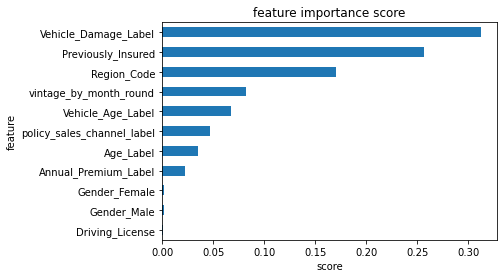

In [83]:
feat_importances = pd.Series(rf_param.feature_importances_,index=xtrain.columns)
ax=feat_importances.nlargest(11).plot(kind='barh')
ax.invert_yaxis()
plt.xlabel('score')
plt.ylabel('feature')
plt.title('feature importance score')

**Let's try to remove unimportant feature (driving license and gender)**

In [84]:
x1=train1.drop(['Response','Driving_License','Gender_Female'],axis=1)
y1=train1['Response']
xtrain1,xtest1,ytrain1,ytest1=train_test_split(x1,y1,test_size=0.3,random_state=42)

In [85]:
rf_param=RandomForestClassifier(random_state= 42,
                          n_estimators = 1000,
                          max_depth = 40,
                          min_samples_leaf=1)
rf_param.fit(xtrain1,ytrain1)

RandomForestClassifier(max_depth=40, n_estimators=1000, random_state=42)

In [86]:
ypred_param1 = rf_param.predict(xtest1)
print('accuracy')
print(accuracy_score(ytest1, ypred_param1))
print('')
print('precision')
print(precision_score(ytest1, ypred_param1))
print('')
print('recall')
print(recall_score(ytest1, ypred_param1))
print('')
print('roc_auc')
print(roc_auc_score(ytest1,ypred_param1))

accuracy
0.8325732798992738

precision
0.7719012407569871

recall
0.9446608791680726

roc_auc
0.8324509511433085


In [87]:
ypred_param1 = rf_param.predict(xtrain1)
print('accuracy')
print(accuracy_score(ytrain1, ypred_param1))
print('')
print('precision')
print(precision_score(ytrain1, ypred_param1))
print('')
print('recall')
print(recall_score(ytrain1, ypred_param1))
print('')
print('roc_auc')
print(roc_auc_score(ytrain1,ypred_param1))

accuracy
0.8491468280516883

precision
0.7878306437895606

recall
0.9554681636433064

roc_auc
0.8491964804184522


## **From The machine learning experiments above, there are several points that need to be mentioned:**

### Modelling Preparation
- Oversampling is used to handle imbalance data
- The data is split to test (30%) and train (70%) data
- Evaluation metric for the model are ROC-AUC, because the target data is imbalance. However, since the objective of this model is cost optimization, the score which used for implementation is precision score

### Modelling
- Simple Logistic regression, XGBoost, Ada Boost, KNN, Random Forest, and decision tree is used
- Based on the evaluation metric, the best model is random forest classifier

### Post-Modelling
- Next, tuning the hyperparameter of best model (Random Forest Classifier)
- The tuning hyperparameter are n_estimator, max_depth, and min_samples_leaf with consideration can avoid random forest model from over fitting. 
- However, since we can't use randomized or grid search due to technical constraint, the performance of random forest become lower. We decide to not tune the parameter.
- We also try to remove unimportant feature. After removing the unimportant feature, the evaluation metric is not getting better. So we decide to keep all features in the dataset.

## **Business Impact**
- By using this machine learning model, sales agent team can reduce the wasting cost by 65%
- With cost assumption Rs. 3000/customer, ISI can save the operation cost around Rs. 961 million

**Nb: Detail explanation available in the final report**